# **Initialization**

In [79]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import cm, pyplot as plot

import warnings, numpy, pandas
from pathlib import Path
from umap import UMAP   
from PIL import Image

warnings.filterwarnings('ignore')

SIZE = (224, 224)
PATH = Path('Data/Clustering')  
LABELS = ['realistic', 'features', 'blurred', 'geons', 'silhouettes']
CLUSTER_NAMES = ['airplane', 'car', 'chair', 'cup', 'dog', 'donkey', 'duck', 'hat']

In [80]:
data = {}

for label in LABELS:
    components = []
    for file in sorted((PATH/label).iterdir()):
        image = Image.open(file).convert('L').resize(SIZE, Image.Resampling.LANCZOS)
        components.append(numpy.array(image, dtype=numpy.float32).flatten())
    components = numpy.array(components)
    scaler = StandardScaler()
    data[label] = {'components': scaler.fit_transform(components), 'scaler': scaler}
    

- `.convert('L')` converts the image to grayscale; The 'L' stands for Luminance channel or 8-bit grayscale. 'L' mode images have one channel per pixel (unlike 'RGB' which has three: red, green, blue).
- **Keeping the scaler:** To visually reconstruct images that can be compared with the originals, we must reverse this standardization using the same scaler.
> **Resampling**
>
> Resampling is the process of changing the dimensions of an image by adding or removing pixels when resizing it to a standardized size. LANCZOS method is a high-quality interpolation algorithm that calculates new pixel values when the image size changes.​ LANCZOS resampling uses a mathematical technique that looks at multiple surrounding pixels and computes a weighted average to determine each new pixel's value. This preserves image quality better than simpler methods like nearest neighbor, which just copies the closest pixel value.​

# **Principal Component Analysis (PCA)**

In [81]:
pca_results = {}

for label in LABELS:    
    components = data[label]['components']    
    pca_model = PCA(n_components=min(components.shape))
    principal_components = pca_model.fit_transform(components)
    cumulative_variance = numpy.cumsum(pca_model.explained_variance_ratio_)
    minimum_components = numpy.argmax(cumulative_variance >= 0.95) + 1 if numpy.any(cumulative_variance >= 0.95) else len(cumulative_variance)
    pca_results[label] = {
        'pca_model': pca_model,
        'principal_components': principal_components,
        'scaler': data[label]['scaler'],
        'explained_variance': pca_model.explained_variance_ratio_,
        'cumulative_variance': cumulative_variance,
        'minimum_components_95': minimum_components
    }
    preserved_variance = cumulative_variance[minimum_components - 1]
    print(f'Label: {label}\nMinimum Number of Components: {minimum_components}\nPreserved Variance: {preserved_variance:.4f}')
    if label != LABELS[-1]:
            print()

Label: realistic
Minimum Number of Components: 30
Preserved Variance: 0.9531

Label: features
Minimum Number of Components: 33
Preserved Variance: 0.9573

Label: blurred
Minimum Number of Components: 23
Preserved Variance: 0.9530

Label: geons
Minimum Number of Components: 39
Preserved Variance: 0.9520

Label: silhouettes
Minimum Number of Components: 31
Preserved Variance: 0.9566


**Why do some conditions require more components than others?**

The number of principal components needed to preserve 95% of variance varies across conditions due to differences in image complexity and information content:

- **Blurred (23 components)**: Requires the fewest components because blurring removes high-frequency details, resulting in smoother images with less variance to capture. The information is concentrated in fewer dimensions.

- **Realistic (30 components)**: Contains natural photographic detail with textures, lighting variations, and fine features that require more components to represent.

- **Silhouettes (31 components)**: Despite being simplified to binary shapes, the variety of object outlines and edge variations requires moderate complexity to capture.

- **Features (33 components)**: Contains distinctive visual features that vary across objects, requiring additional components to preserve the discriminative information.

- **Geons (39 components)**: Requires the most components because geometric primitives create sharp edges, distinct shapes, and varied 3D structural information that introduces higher variance in the pixel space.

In general, images with more fine-grained details, sharper edges, or greater structural complexity have variance spread across more dimensions, requiring more principal components to reach the 95% threshold.

- `X.shape = (sample_count, feature_count)`; If we only have `n` data points (samples). We cannot find more than `n` independent patterns from them. `PCA(n_components=min(X.shape))` is a safety measure that works for both cases.
- Standardizing the pixel values for each label by centering them around zero and scaling them to unit variance is essential for PCA to work properly. If we standardized all the data together, differences between labels could be lost, and PCA might mix up the underlying patterns you want to analyze in each group.
- `argmax` finds the first index where the specified condition is `True`, but if there are none, it returns 0 by default, making `n_comp_95 = 1`, which is misleading.
- PCA is applied to find the principal components — new axes that capture the most variation in the data. The `n_components=min(X.shape)` ensures PCA computes as many components as possible given the data dimensions.
- The `explained_variance_ratio_` shows what percentage of total variance each principal component captures. The `cumulative_variance` sums these ratios to show how much total variance is explained by the first `n` components.
- `n_comp_95 = numpy.argmax(cumsum >= 0.95) + 1` finds the minimum number of components needed to explain at least 95% of the variance in the data. For example, if the original data has 262,144 dimensions (512×512 pixels), we might only need 50 components to capture 95% of the information — a massive dimensionality reduction.

# **Original vs PCA-Reconstructed Realistic Images (95% Variance Retained)**

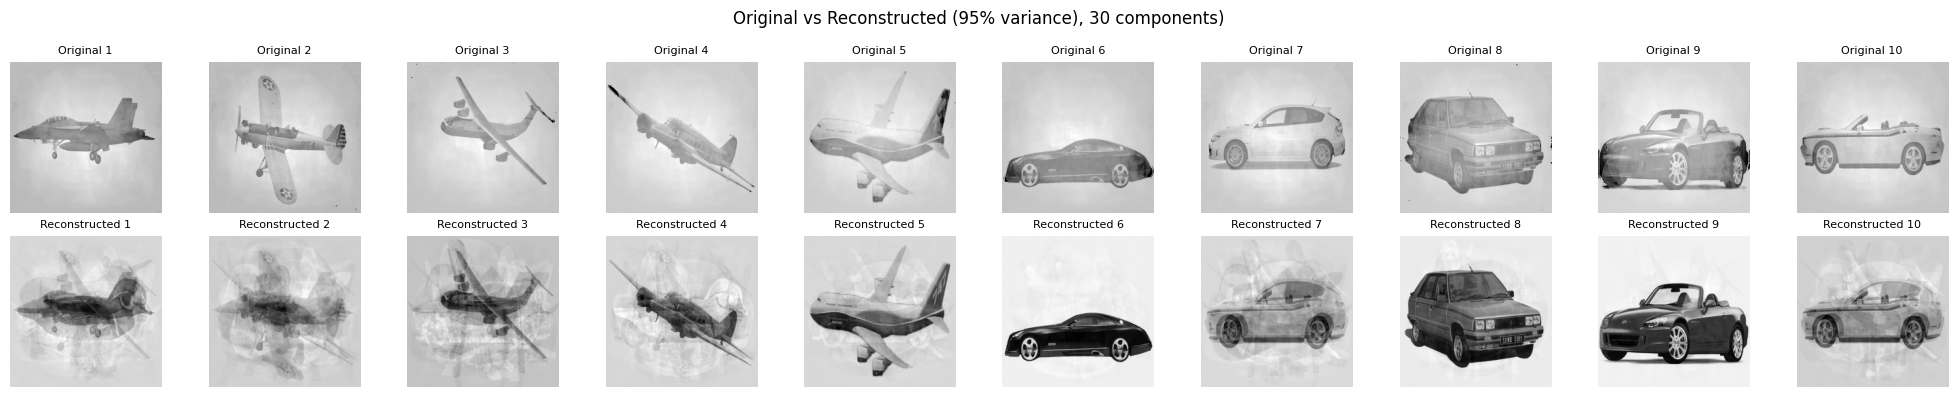

In [82]:
components = data['realistic']['components']
pca_model = pca_results['realistic']['pca_model']
cumulative_variance = pca_results['realistic']['cumulative_variance']
minimum_components = pca_results['realistic']['minimum_components_95']
principal_components = pca_results['realistic']['principal_components'][:, :minimum_components]
principal_components_padded = numpy.column_stack([principal_components, numpy.zeros((principal_components.shape[0], pca_model.n_components_ - minimum_components))])
principal_components_reconstructed = pca_results['realistic']['scaler'].inverse_transform(pca_model.inverse_transform(principal_components_padded))

figures, axes = plot.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    original = components[i].reshape(SIZE)
    reconstructed = principal_components_reconstructed[i].reshape(SIZE)
    axes[0, i].imshow(original, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {i+1}', fontsize=8)
    axes[1, i].imshow(reconstructed, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Reconstructed {i+1}', fontsize=8)

plot.suptitle(f'Original vs Reconstructed (95% variance), {minimum_components} components)', fontsize=12)
plot.tight_layout()
plot.show()

# **2D Scatter Plots by Image Cluster**

Visualizing images in 2D space using the first two principal components. Each point represents an image, colored by its cluster (Airplane, Car, Chair, Cup, Dog, Donkey, Duck, Hat).

## **Principal Component Analysis**

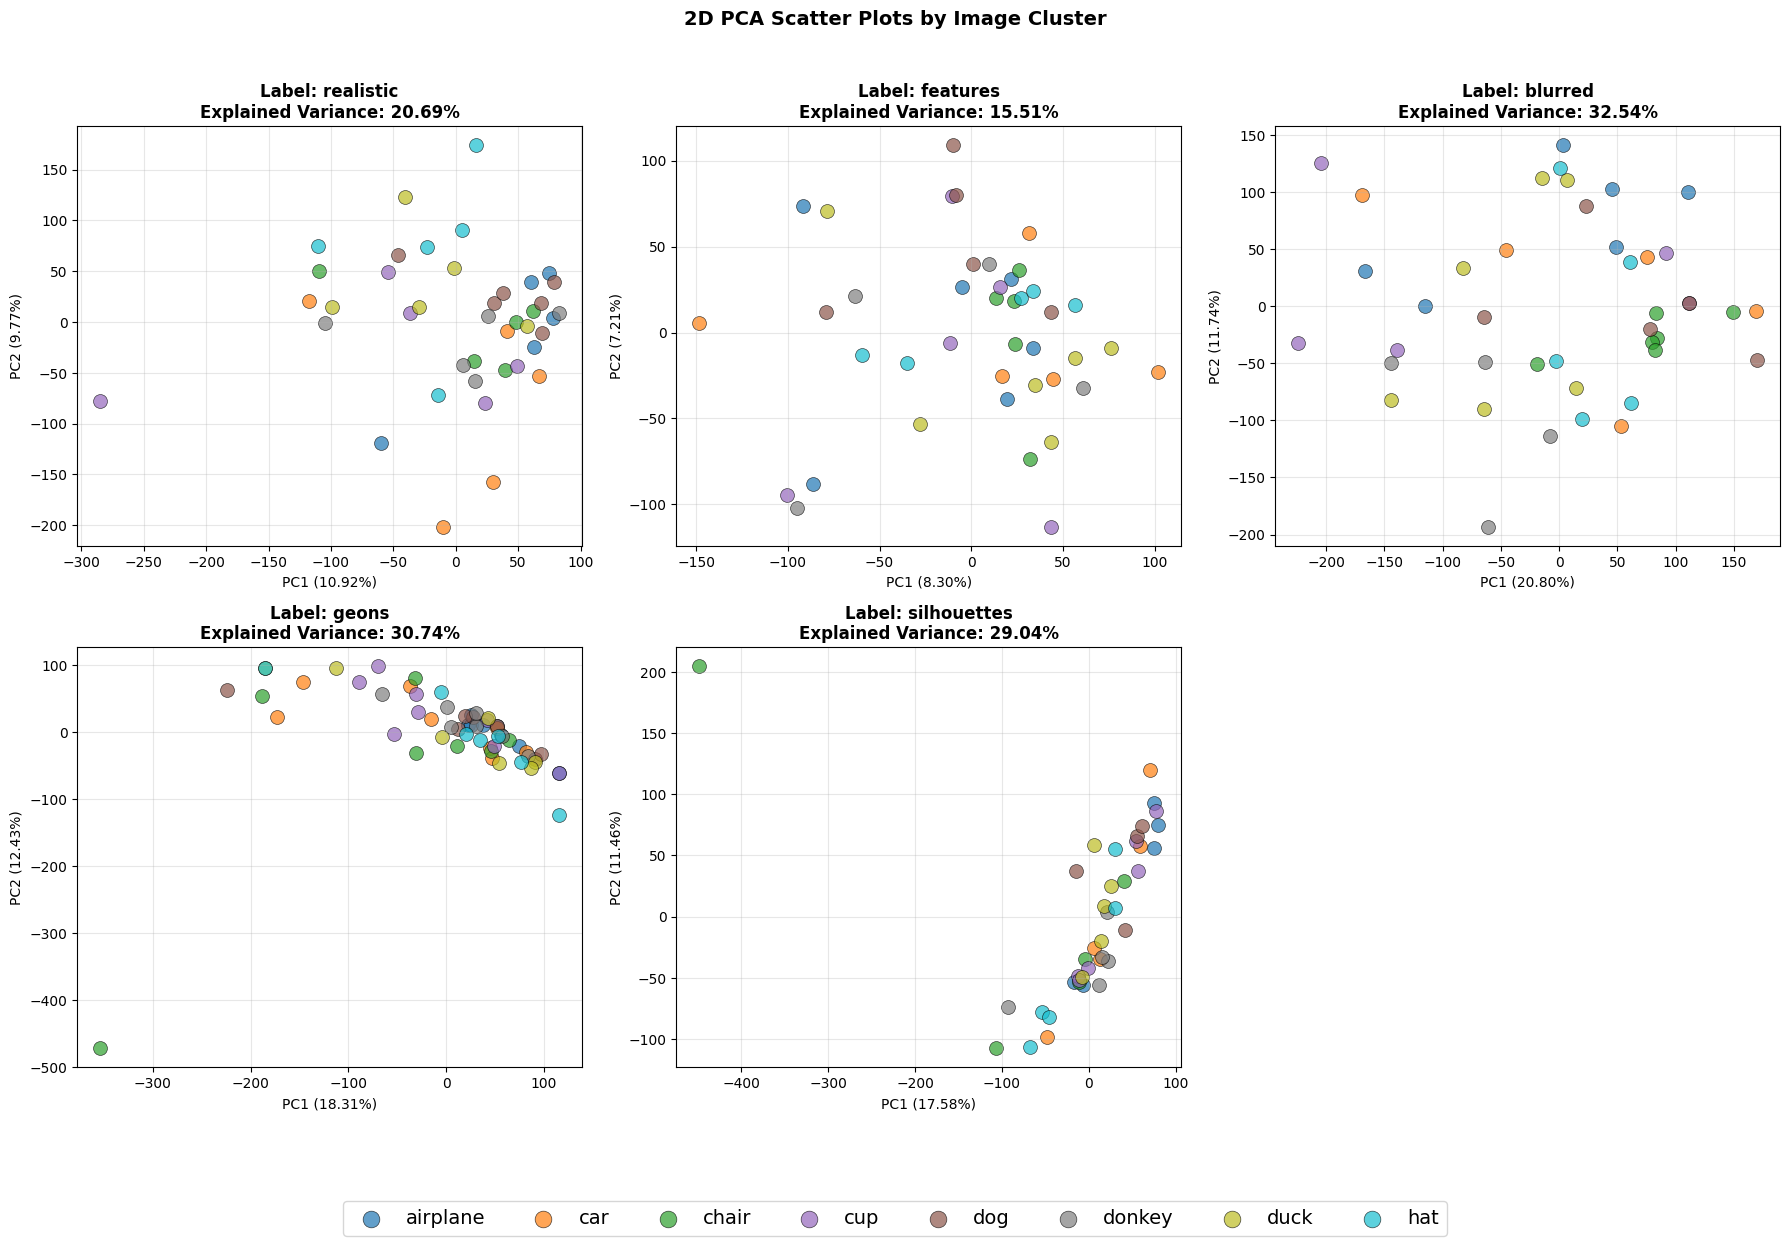

In [83]:
cmap = cm.get_cmap('tab10', len(CLUSTER_NAMES))
cluster_colors = {cluster_name: cmap(index) for index, cluster_name in enumerate(CLUSTER_NAMES)}

figure, axes = plot.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

legend_handles = []
legend_labels = []

for index, label in enumerate(LABELS):
    pca_model = PCA(n_components=2)
    principal_components = pca_model.fit_transform(data[label]['components'])
    cumulative_variance = numpy.sum(pca_model.explained_variance_ratio_)
    
    clusters = []    
    paths = (PATH / label).iterdir()

    for path in paths: 
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem.lower()), 'Unknown')
        clusters.append(cluster_name)
    
    axis = axes[index]  
    
    for cluster in CLUSTER_NAMES:         
        cluster_indices = [i for i, cluster_name in enumerate(clusters) if cluster_name == cluster]        
        scatter = axis.scatter(
            principal_components[cluster_indices, 0], 
            principal_components[cluster_indices, 1], 
            color=cluster_colors[cluster], 
            label=cluster, 
            alpha=0.7, 
            s=100,
            edgecolors='black',
            linewidth=0.5
        )
            
        if index == 0: 
            legend_handles.append(scatter)
            legend_labels.append(cluster)
    
    axis.set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.2%})', fontsize=10)
    axis.set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.2%})', fontsize=10)
    axis.set_title(f'Label: {label}\nExplained Variance: {cumulative_variance:.2%}', fontsize=12, fontweight='bold')
    axis.grid(True, alpha=0.3)

if len(LABELS) < len(axes):
    figure.delaxes(axes[-1])

figure.legend(legend_handles, legend_labels, 
    loc='lower center', 
    ncol=len(CLUSTER_NAMES), 
    fontsize=14,
    markerscale=1.2,
    frameon=True,
    bbox_to_anchor=(0.5, -0.05)
) 

plot.suptitle('2D PCA Scatter Plots by Image Cluster', fontsize=14, fontweight='bold')
plot.tight_layout(rect=(0, 0.05, 1, 0.96)) 
plot.show()

**Interpretation**

The main goal of this visualization is to see if the pre-defined **`CLUSTER_NAMES`** are meaningful and well-separated in the feature space:

1.  **Cluster Separation:**
    * **Good Separation:** If dots of the same color are tightly grouped together, and these groups are far apart from groups of different colors, it indicates that your feature representation is effective at **distinguishing between the clusters**.
    * **Poor Separation:** If dots of different colors are heavily mixed or overlap, it suggests that the features captured by the PCA model do not clearly differentiate between those specific clusters.

2.  **Cluster Compactness:**
    * A **tight, dense grouping** of points of the same color indicates that the features within that cluster are very similar to each other.
    * A **sparse, spread-out grouping** suggests that the features within that cluster have high internal variance (the cluster is diverse).

3.  **Variance Explained:**
    * The subplot title shows the **Total Explained Variance** (the sum of variance explained by PC1 and PC2). A higher percentage (e.g., 85%) means the 2D plot is a very accurate representation of the original high-dimensional data structure.
    * The axis labels show the individual variance explained by PC1 and PC2. Typically, PC1 explains significantly more variance than PC2.

## **t-Distributed Stochastic Neighbor Embedding**

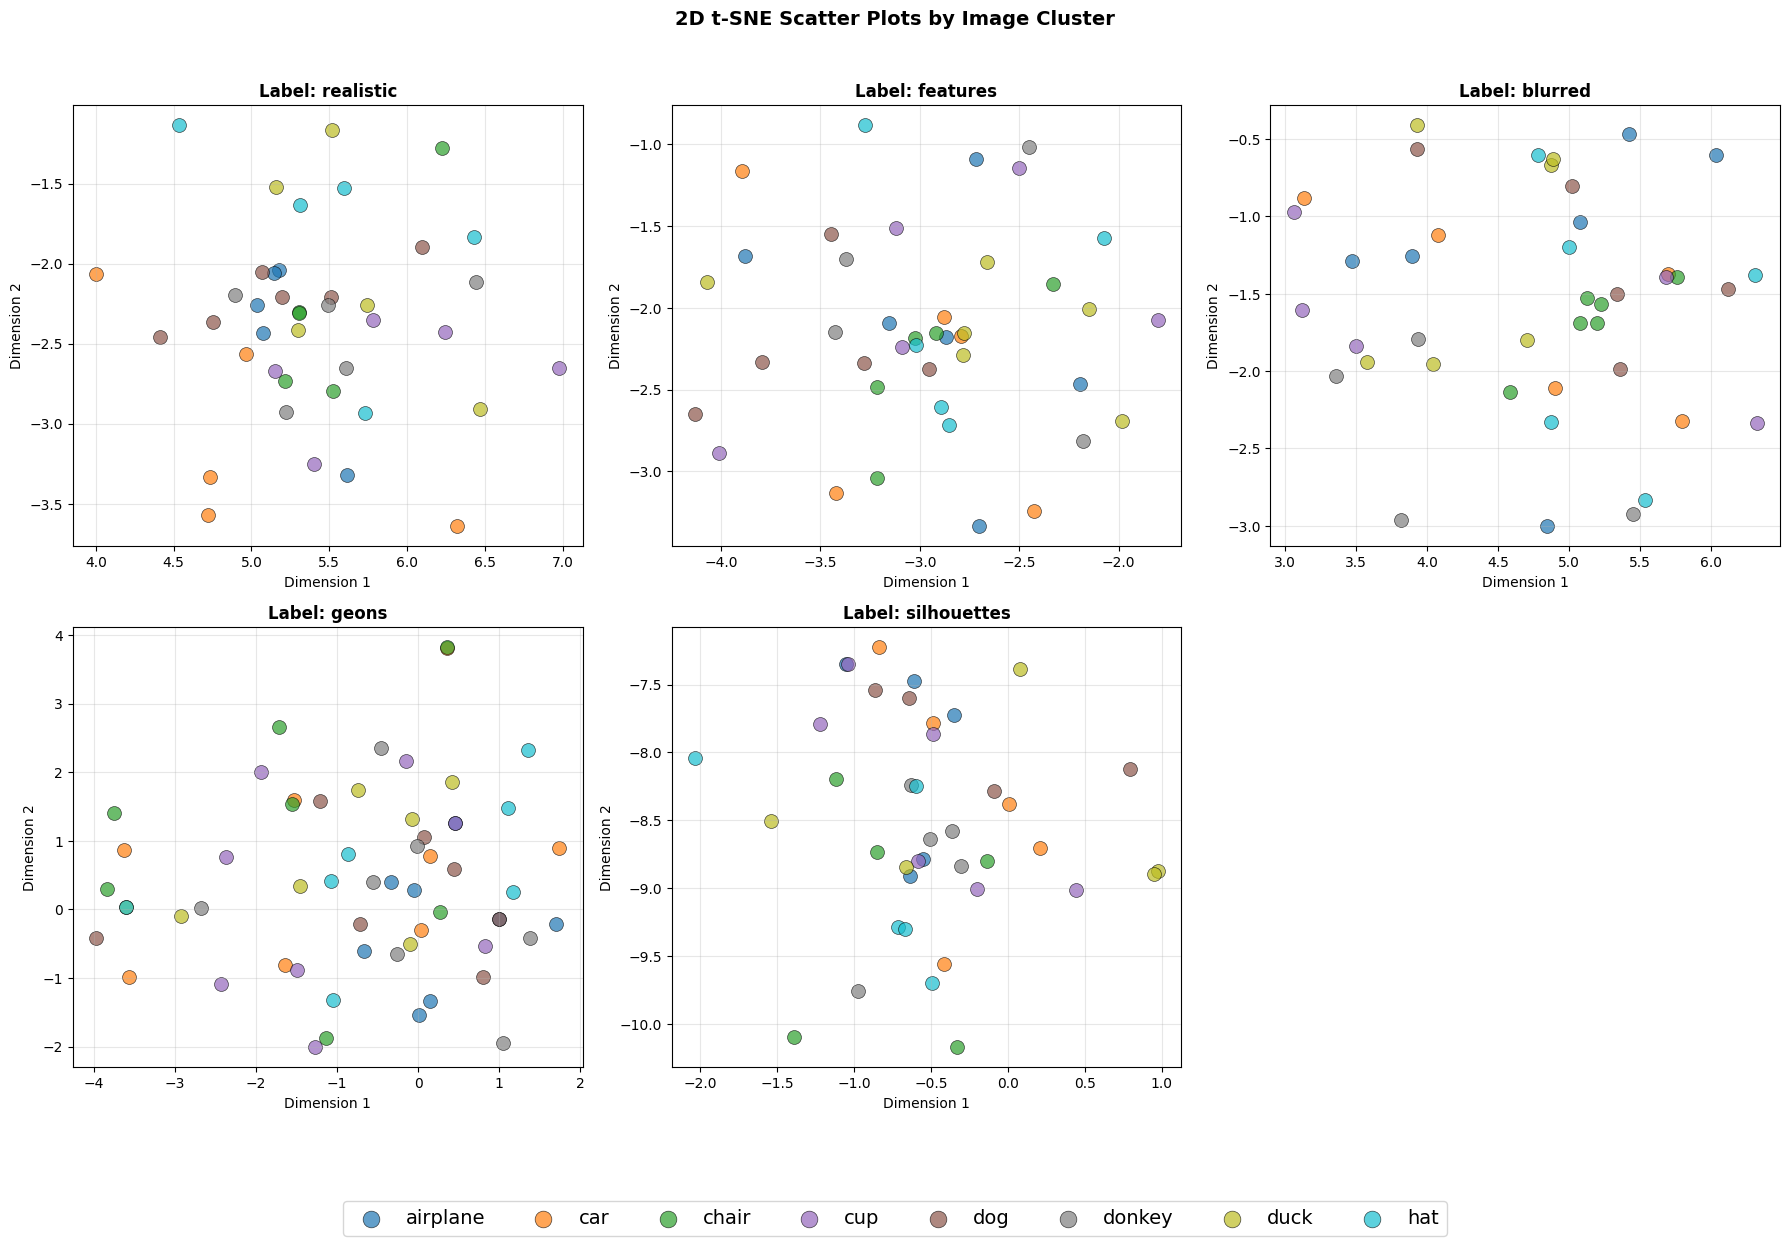

In [84]:
figure, axes = plot.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

legend_handles = []
legend_labels = []

for index, label in enumerate(LABELS):
    tsne_model = TSNE(n_components=2, random_state=42, perplexity=30)
    principal_components = tsne_model.fit_transform(data[label]['components'])
    
    clusters = []    
    paths = (PATH / label).iterdir()
    for path in paths: 
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem.lower()), 'Unknown')
        clusters.append(cluster_name)
    
    axis = axes[index]  
    for cluster in CLUSTER_NAMES:         
        cluster_indices = [i for i, cluster_name in enumerate(clusters) if cluster_name == cluster]        
        if cluster_indices:  
            scatter = axis.scatter(
                principal_components[cluster_indices, 0], 
                principal_components[cluster_indices, 1], 
                color=cluster_colors[cluster], 
                label=cluster, 
                alpha=0.7, 
                s=100,
                edgecolors='black',
                linewidth=0.5
            )
            if index == 0: 
                legend_handles.append(scatter)
                legend_labels.append(cluster)
    
    axis.set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.2%})', fontsize=10)
    axis.set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.2%})', fontsize=10)
    axis.set_xlabel('Dimension 1', fontsize=10)
    axis.set_ylabel('Dimension 2', fontsize=10)
    axis.set_title(f'Label: {label}', fontsize=12, fontweight='bold')
    axis.grid(True, alpha=0.3)

if len(LABELS) < len(axes):
    figure.delaxes(axes[-1])

figure.legend(legend_handles, legend_labels, 
              loc='lower center', 
              ncol=len(CLUSTER_NAMES), 
              fontsize=14,
              markerscale=1.2,
              frameon=True,
              bbox_to_anchor=(0.5, -0.05)) 

plot.suptitle('2D t-SNE Scatter Plots by Image Cluster', fontsize=14, fontweight='bold')
plot.tight_layout(rect=(0, 0.05, 1, 0.96)) 
plot.show()

Perplexity controls the balance between preserving local vs. global structure in t-SNE. It represents the effective number of neighbors each point considers during optimization.
- Low perplexity (e.g., 5-10): Focuses on local neighborhood structure; can fragment into many small disconnected clusters
- Perplexity=30: Standard middle ground; good for most datasets (typical range is 5-50)
- High perplexity (e.g., 50+): Emphasizes global structure; smoother, more connected embeddings
- Perplexity should ideally be between 5 and dataset_size/100.

## **Locally Linear Embedding**

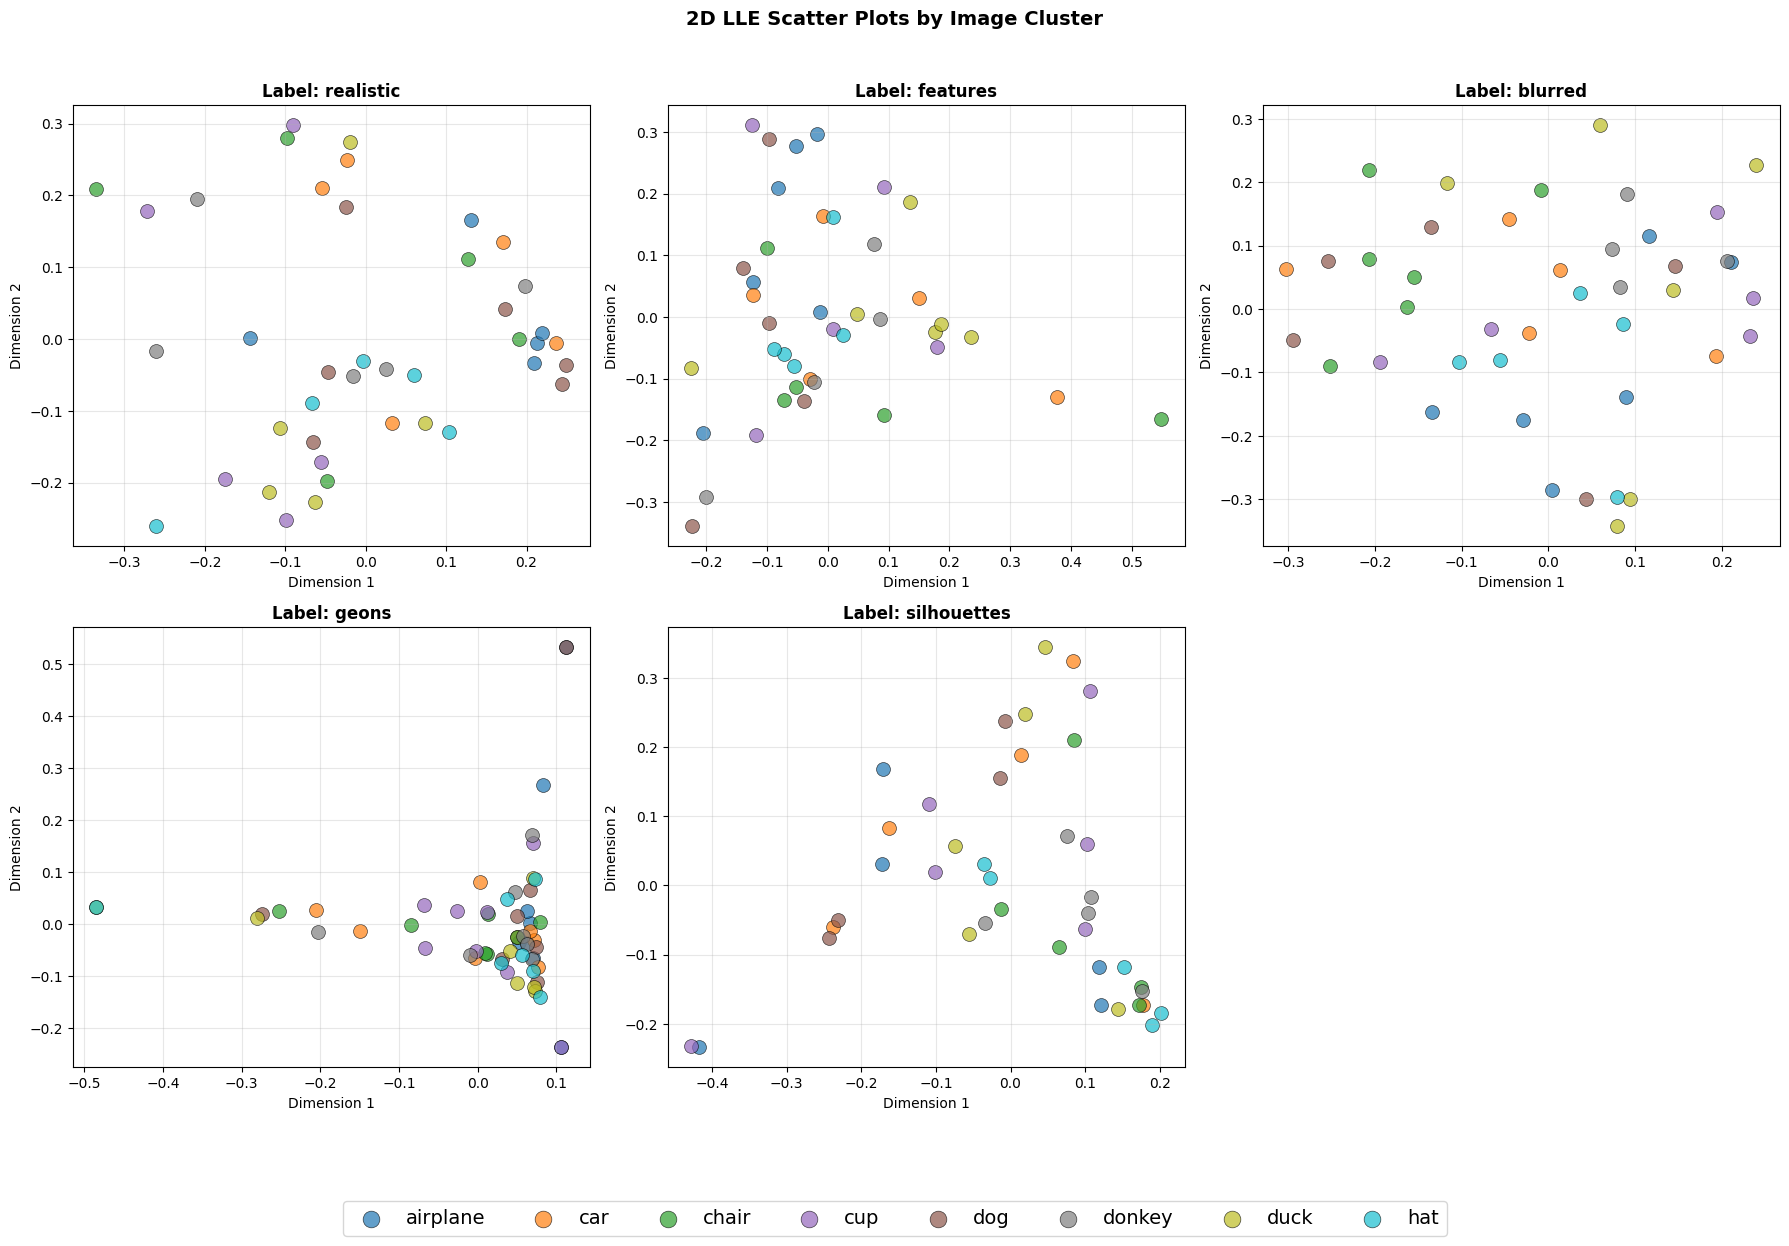

In [85]:
figure, axes = plot.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

legend_handles = []
legend_labels = []

for index, label in enumerate(LABELS):
    lle_model = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
    principal_components = lle_model.fit_transform(data[label]['components'])    
    clusters = []    
    paths = (PATH / label).iterdir()
    for path in paths: 
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem.lower()), 'Unknown')
        clusters.append(cluster_name)
    
    axis = axes[index]  
    for cluster in CLUSTER_NAMES:         
        cluster_indices = [i for i, cluster_name in enumerate(clusters) if cluster_name == cluster]        
        if cluster_indices:  
            scatter = axis.scatter(
                principal_components[cluster_indices, 0], 
                principal_components[cluster_indices, 1], 
                color=cluster_colors[cluster], 
                label=cluster, 
                alpha=0.7, 
                s=100,
                edgecolors='black',
                linewidth=0.5
            )
            if index == 0: 
                legend_handles.append(scatter)
                legend_labels.append(cluster)
                
    axis.set_xlabel('Dimension 1', fontsize=10)
    axis.set_ylabel('Dimension 2', fontsize=10)
    axis.set_title(f'Label: {label}', fontsize=12, fontweight='bold')
    axis.grid(True, alpha=0.3)

if len(LABELS) < len(axes):
    figure.delaxes(axes[-1])

figure.legend(legend_handles, legend_labels, 
              loc='lower center', 
              ncol=len(CLUSTER_NAMES), 
              fontsize=14,
              markerscale=1.2,
              frameon=True,
              bbox_to_anchor=(0.5, -0.05)) 

plot.suptitle('2D LLE Scatter Plots by Image Cluster', fontsize=14, fontweight='bold')
plot.tight_layout(rect=(0, 0.05, 1, 0.96)) 
plot.show()

## **Uniform Manifold Approximation and Projection**

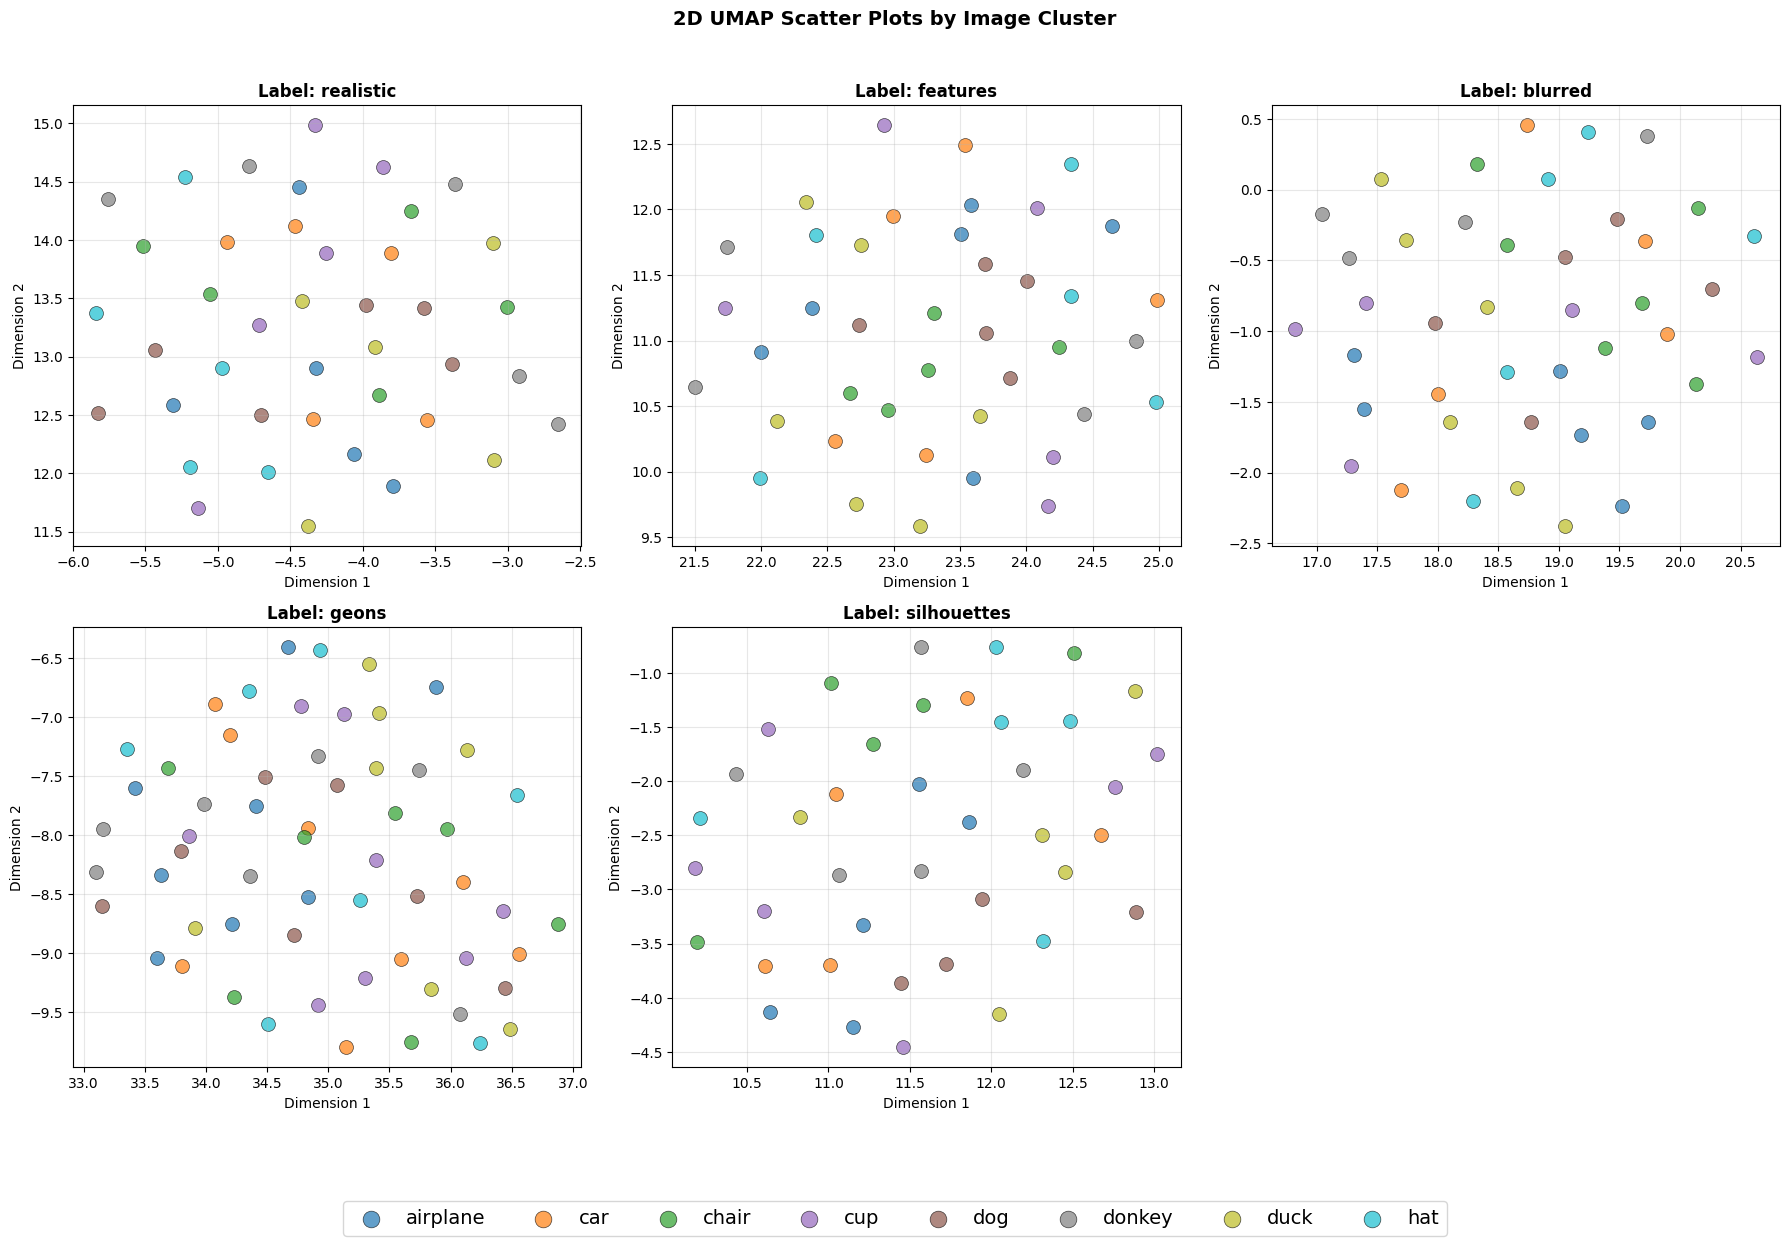

In [86]:
figure, axes = plot.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

legend_handles = []
legend_labels = []

for index, label in enumerate(LABELS):
    umap_model = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    principal_components = numpy.array(umap_model.fit_transform(data[label]['components']))
    
    clusters = []    
    paths = (PATH / label).iterdir()
    for path in paths: 
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem.lower()), 'Unknown')
        clusters.append(cluster_name)
    
    axis = axes[index]  
    for cluster in CLUSTER_NAMES:         
        cluster_indices = [i for i, cluster_name in enumerate(clusters) if cluster_name == cluster]        
        if cluster_indices:  
            scatter = axis.scatter(
                principal_components[cluster_indices, 0], 
                principal_components[cluster_indices, 1], 
                color=cluster_colors[cluster], 
                label=cluster, 
                alpha=0.7, 
                s=100,
                edgecolors='black',
                linewidth=0.5
            )
            if index == 0: 
                legend_handles.append(scatter)
                legend_labels.append(cluster)
    
    axis.set_xlabel('Dimension 1', fontsize=10)
    axis.set_ylabel('Dimension 2', fontsize=10)
    axis.set_title(f'Label: {label}', fontsize=12, fontweight='bold')
    axis.grid(True, alpha=0.3)

if len(LABELS) < len(axes):
    figure.delaxes(axes[-1])

figure.legend(legend_handles, legend_labels, 
              loc='lower center', 
              ncol=len(CLUSTER_NAMES), 
              fontsize=14,
              markerscale=1.2,
              frameon=True,
              bbox_to_anchor=(0.5, -0.05)) 

plot.suptitle('2D UMAP Scatter Plots by Image Cluster', fontsize=14, fontweight='bold')
plot.tight_layout(rect=(0, 0.05, 1, 0.96)) 
plot.show()

Label: realistic
best_k_inertias = 2
best_k_silhouette = 2

Label: features
best_k_inertias = 2
best_k_silhouette = 5

Label: blurred
best_k_inertias = 2
best_k_silhouette = 2

Label: geons
best_k_inertias = 2
best_k_silhouette = 2

Label: silhouettes
best_k_inertias = 2
best_k_silhouette = 2


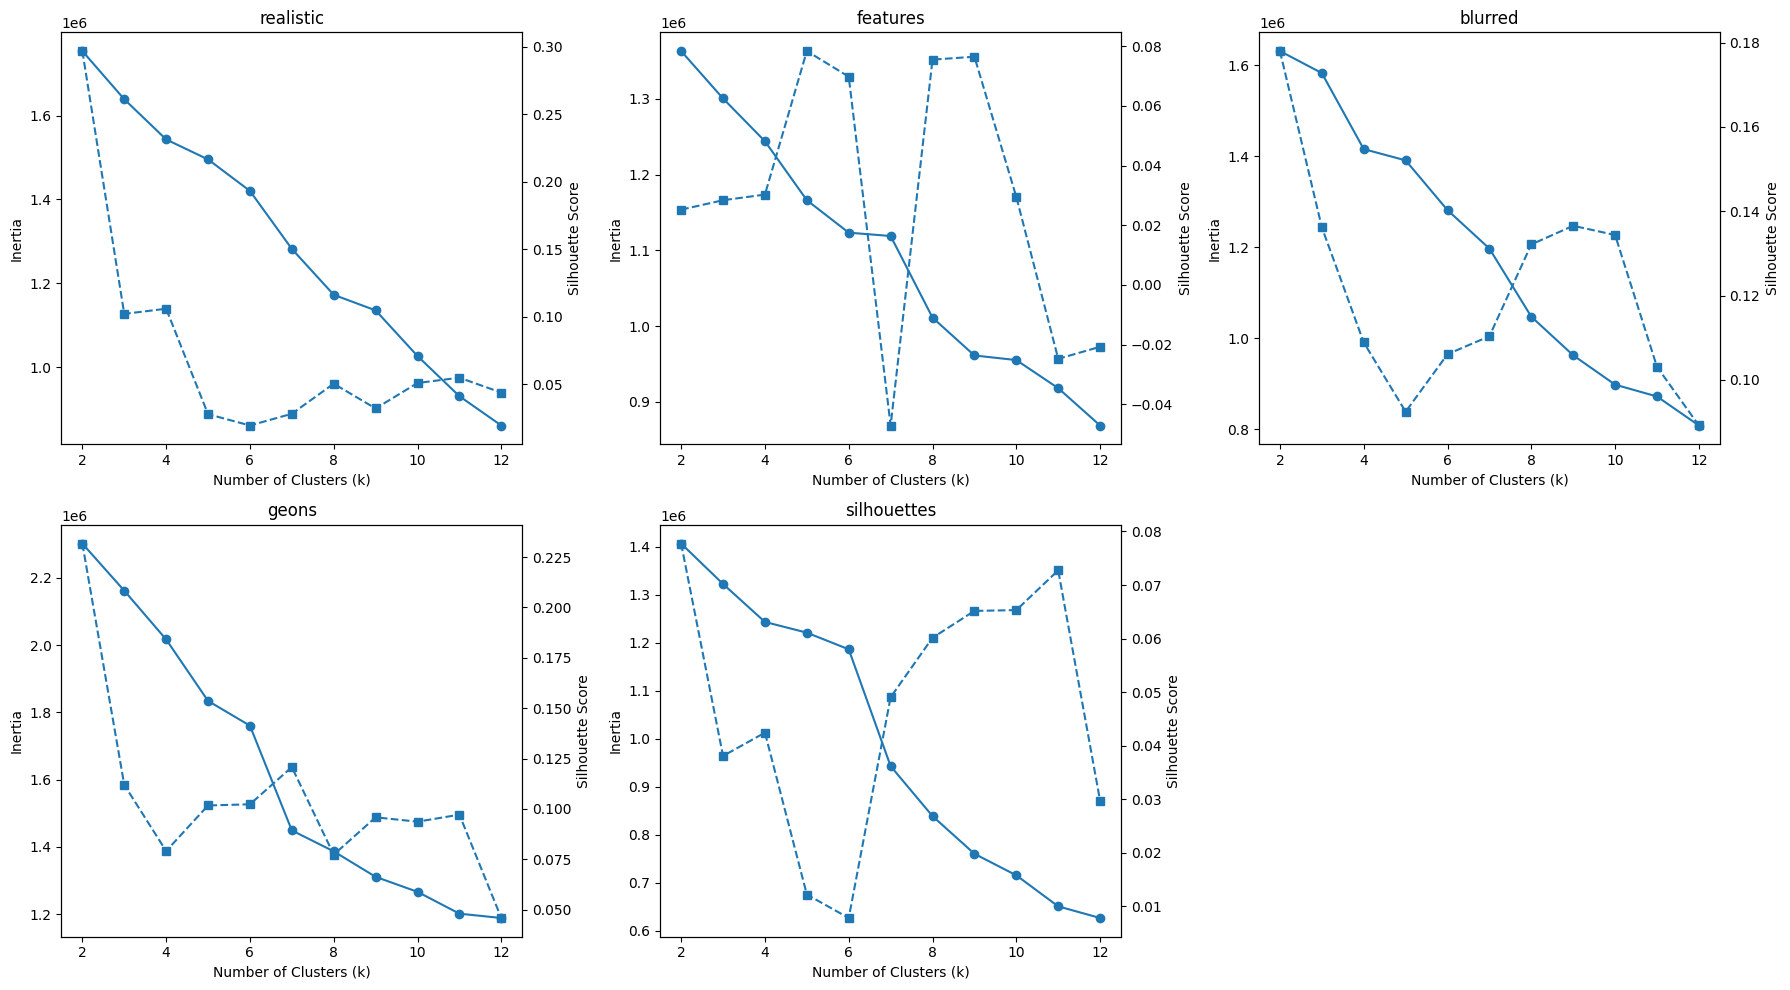

In [87]:
k_range = range(2, 13) 
kmeans_results = {}

for label in LABELS:
    cumulative_variance = pca_results[label]['cumulative_variance']
    minimum_components =  pca_results[label]['minimum_components_95']
    principal_components = pca_results[label]['principal_components'][:, :minimum_components]

    inertias = []
    silhouettes = []

    for k in k_range:
        kmeans_model = KMeans(
            n_clusters=k,
            random_state=42,
            n_init="auto"
        )
        cluster_labels = kmeans_model.fit_predict(principal_components)
        inertias.append(kmeans_model.inertia_)
        silhouettes.append(silhouette_score(principal_components, cluster_labels))

    best_k_silhouette = k_range[numpy.argmax(silhouettes)]
    best_k_inertias = k_range[numpy.argmax(inertias)]

    kmeans_results[label] = {
        'principal_components': principal_components,
        'inertias': inertias,
        'silhouettes': silhouettes,
        'best_k': best_k_silhouette
    }

    print(f"Label: {label}\nbest_k_inertias = {best_k_inertias}\nbest_k_silhouette = {best_k_silhouette}")
    if label != LABELS[-1]:
        print()
    
figure, axes = plot.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for index, label in enumerate(LABELS):
    axis = axes[index]
    axis_secondary = axis.twinx()

    inertias = kmeans_results[label]['inertias']
    silhouettes = kmeans_results[label]['silhouettes']

    axis.plot(k_range, inertias, marker='o')
    axis.set_xlabel("Number of Clusters (k)")
    axis.set_ylabel("Inertia")

    axis_secondary.plot(k_range, silhouettes, marker='s', linestyle='--')
    axis_secondary.set_ylabel("Silhouette Score")

    axis.set_title(label)

plot.tight_layout()

if len(LABELS) < len(axes):
    figure.delaxes(axes[-1])

# **K-Means Clustering**

K-Means is an algorithm that groups similar data points together. It looks for patterns in data without having any pre-existing labels (unsupervised).

  * **The Goal:** Partition your data into $k$ distinct non-overlapping subgroups (clusters).
  * **The Mechanism:** It tries to make the data points within a cluster as similar as possible while keeping the clusters as far apart as possible.

`kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")`

  * **`n_clusters=k`**: The specific number of groups the algorithm will try to find for this iteration of the loop.
  * **`n_init="auto"`**: K-Means can sometimes get "unlucky" with where it starts. This tells the algorithm to run the initialization several times and pick the best starting spots automatically.


`cluster_labels = kmeans.fit_predict(X_pca)`

  * **Fit:** The algorithm calculates the geometric center (centroid) of the clusters. It iterates back and forth:
    1.  Assign points to the nearest centroid.
    2.  Move the centroid to the average location of those points.
  * **Predict:** It assigns a label (e.g., 0, 1, 2...) to every row in `X_pca`.
  * **Result:** `cluster_labels` is an array telling us which group every specific data point belongs to.

**The Metrics**

**Metric 1: Inertia (The Elbow Method)**

`inertias.append(kmeans.inertia_)`

  * **What it is:** The "Sum of Squared Errors." It measures how tightly grouped the clusters are.
  * **Math:** It calculates the distance between every data point and the center of its assigned cluster.
  * **Interpretation:** **Lower is better.** However, inertia *always* goes down as you add more clusters (if you have as many clusters as data points, inertia is 0).
  * **The "Elbow":** You look for the point in the plot where the line flattens out (the "elbow"). That indicates that adding more clusters isn't giving you much better grouping.

**Metric 2: Silhouette Score**

`silhouettes.append(silhouette_score(principal_components, cluster_labels))`

  * **What it is:** A measure of how similar a point is to its own cluster (cohesion) compared to other clusters (separation).
  * **Range:** $-1$ to $+1$.
      * **$+1$**: Perfectly clustered (far away from neighbors).
      * **$0$**: The point is on the border between two clusters.
      * **$-1$**: The point is likely in the wrong cluster.
  * **Our Strategy:**
    `best_k = k_range[numpy.argmax(silhouettes)]`
    
    We are programmatically selecting the $k$ that yielded the **highest** silhouette score. This is generally a more robust method than just "eyeballing" the elbow plot.

## **K-Means Clustering with k=8 (Ground Truth)**

realistic    | accuracy = 0.390
features     | accuracy = 0.357
blurred      | accuracy = 0.500
geons        | accuracy = 0.483
silhouettes  | accuracy = 0.500


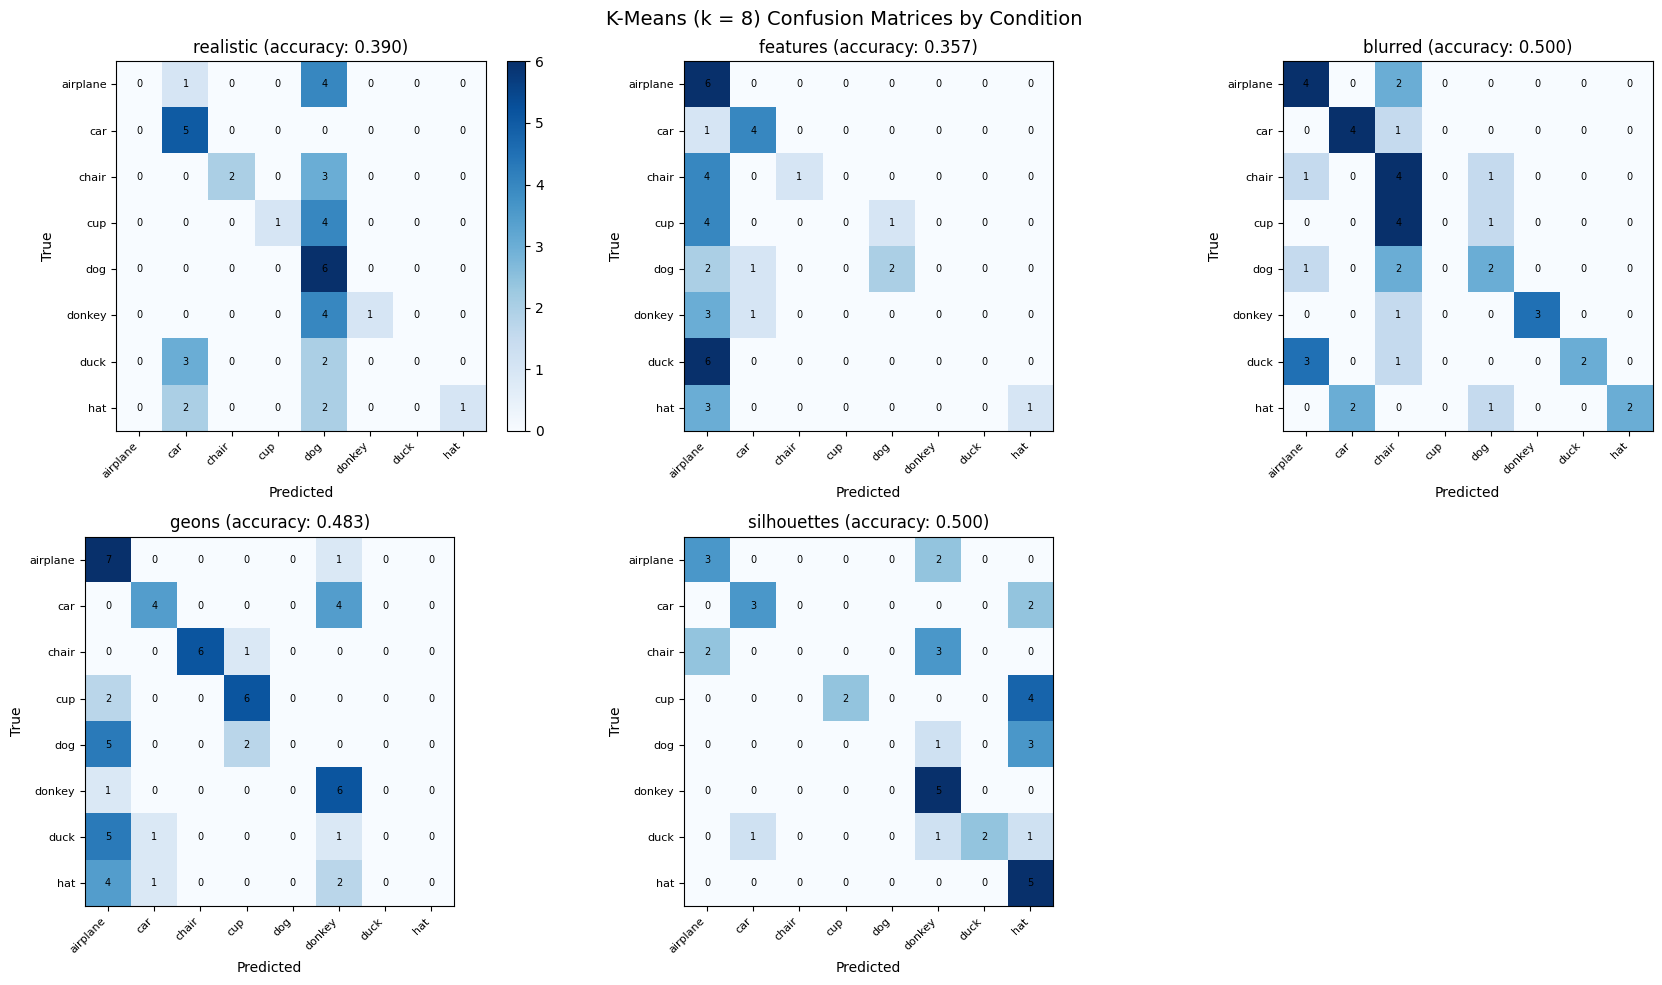

In [88]:
k = 8
confusion_matrices = {}
accuracies = {}

for label in LABELS:
    cumulative_variance = pca_results[label]['cumulative_variance']
    minimum_components = numpy.argmax(cumulative_variance >= 0.95) + 1 if numpy.any(cumulative_variance >= 0.95) else len(cumulative_variance)    
    principal_components = pca_results[label]['principal_components'][:, :minimum_components]

    paths = sorted((PATH / label).iterdir())
    true_labels = []
    for path in paths:
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem.lower()), 'Unknown')
        true_labels.append(cluster_name)
    true_labels = numpy.array(true_labels)

    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    cluster_ids = kmeans_model.fit_predict(principal_components)
    
    cluster_to_class = {}
    for cluster_id in range(k):
        mask = cluster_ids == cluster_id
        if not numpy.any(mask):
            continue
        values, counts = numpy.unique(true_labels[mask], return_counts=True)
        majority_class = values[numpy.argmax(counts)]
        cluster_to_class[cluster_id] = majority_class
    
    pred_labels = numpy.array([cluster_to_class[c] for c in cluster_ids])
    
    cm = confusion_matrix(true_labels, pred_labels, labels=CLUSTER_NAMES)
    confusion_matrices[label] = cm
    accuracy = (true_labels == pred_labels).mean()
    accuracies[label] = accuracy
    print(f"{label:12s} | accuracy = {accuracy:.3f}")

figure, axes = plot.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for index, label in enumerate(LABELS):
    ax = axes[index]
    cm = confusion_matrices[label]
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(f"{label} (accuracy: {accuracies[label]:.3f})", fontsize=12)
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("True", fontsize=10)
    ax.set_xticks(range(len(CLUSTER_NAMES)))
    ax.set_xticklabels(CLUSTER_NAMES, rotation=45, ha="right", fontsize=8)
    ax.set_yticks(range(len(CLUSTER_NAMES)))
    ax.set_yticklabels(CLUSTER_NAMES, fontsize=8)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=7)
    if index == 0:
        figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

for j in range(len(LABELS), len(axes)):
    figure.delaxes(axes[j])

plot.suptitle("K-Means (k = 8) Confusion Matrices by Condition", fontsize=14)
plot.tight_layout()
plot.show()

## **K-Means Clustering with ResNet Features**

Using a pretrained ResNet-18 model to extract deep features from the penultimate layer (before the final classification layer). Images are resized to 224×224 as required by ResNet.

Label: realistic
Shape: (41, 512)

Label: features
Shape: (42, 512)

Label: blurred
Shape: (42, 512)

Label: geons
Shape: (60, 512)

Label: silhouettes
Shape: (40, 512)

K-Means Clustering (k=8) - ResNet Features

realistic    | accuracy = 0.707
features     | accuracy = 0.690
blurred      | accuracy = 0.476
geons        | accuracy = 0.733
silhouettes  | accuracy = 0.775


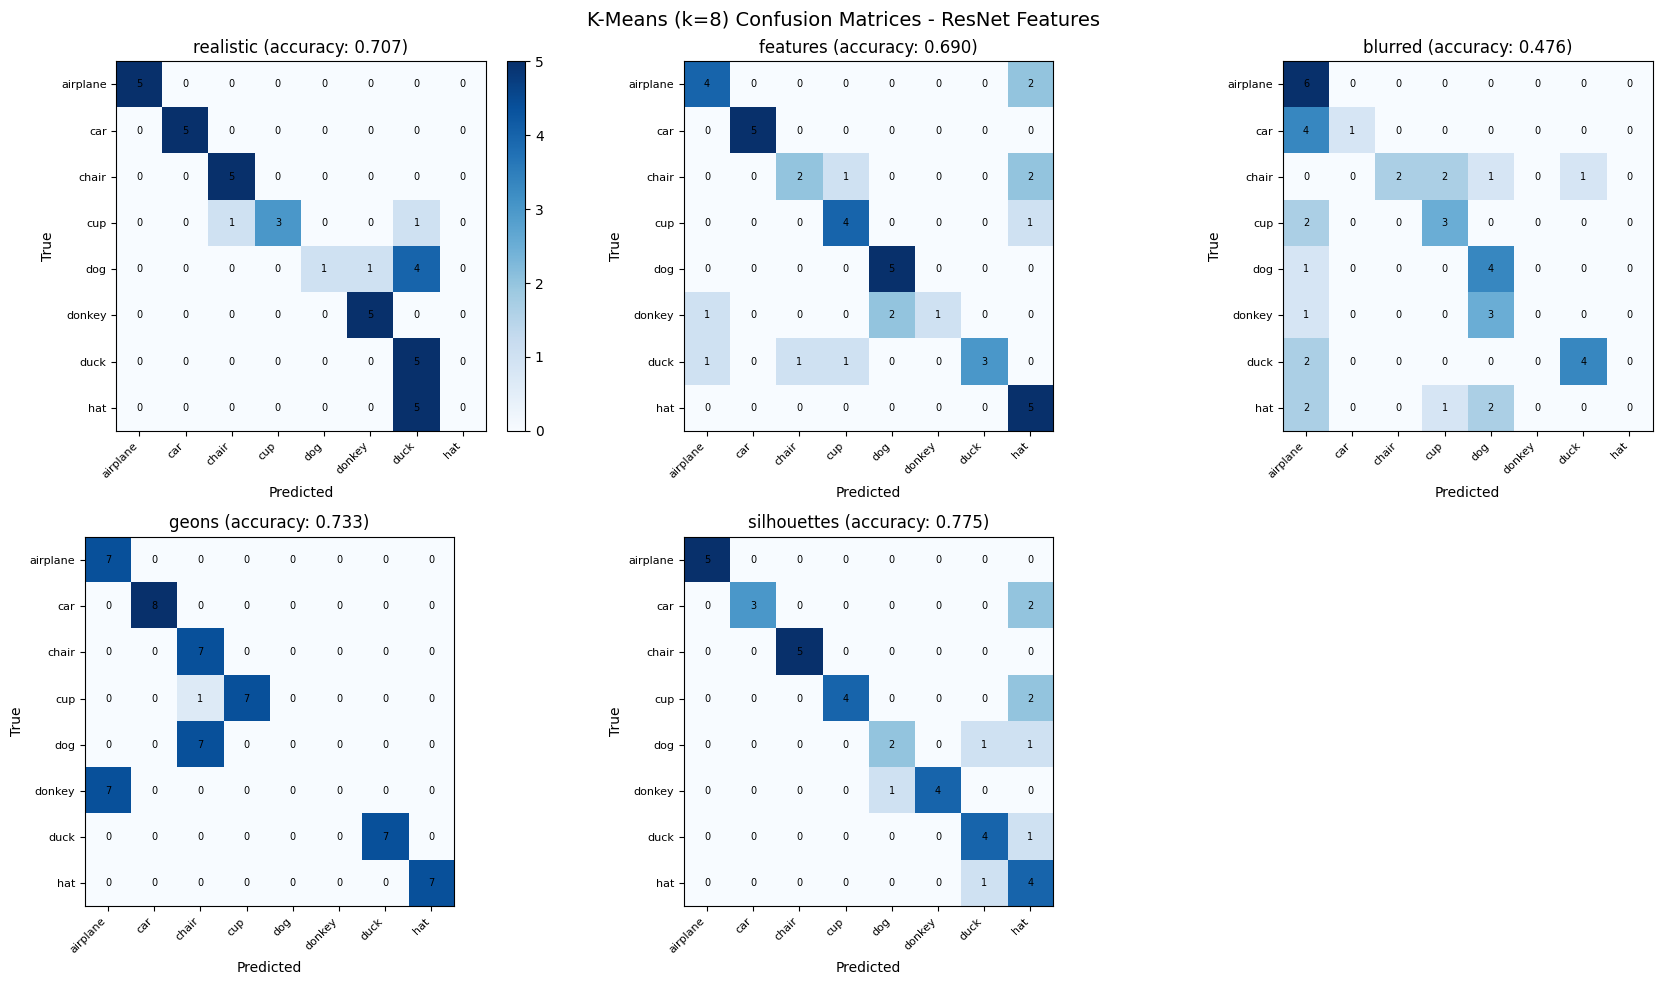

In [89]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
resnet_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet_model = torch.nn.Sequential(*list(resnet_model.children())[:-1])
resnet_model.eval()
resnet_model = resnet_model.to(device)

resnet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

resnet_features = {}
with torch.no_grad():
    for label in LABELS:
        features_list = []
        paths = sorted((PATH / label).iterdir())
        for path in paths:
            image = Image.open(path).convert('RGB')
            image_tensor = torch.tensor(resnet_transforms(image)).unsqueeze(0).to(device)
            features = resnet_model(image_tensor)
            features = features.squeeze().cpu().numpy()
            features_list.append(features)
        features_array = numpy.array(features_list)
        resnet_features[label] = features_array
        print(f'Label: {label}\nShape: {features_array.shape}')
        if label != LABELS[-1]:
            print()

k = 8
confusion_matrices = {}
accuracies = {}

print(f'\n{"="*50}')
print(f'K-Means Clustering (k={k}) - ResNet Features')
print(f'{"="*50}\n')

for label in LABELS:
    features = resnet_features[label]    
    paths = sorted((PATH / label).iterdir())
    true_labels = []
    for path in paths:
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem.lower()), 'Unknown')
        true_labels.append(cluster_name)
    true_labels = numpy.array(true_labels)
    
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    cluster_ids = kmeans_model.fit_predict(features)
    
    cluster_to_class = {}
    for cluster_id in range(k):
        mask = cluster_ids == cluster_id
        if not numpy.any(mask):
            continue
        values, counts = numpy.unique(true_labels[mask], return_counts=True)
        majority_class = values[numpy.argmax(counts)]
        cluster_to_class[cluster_id] = majority_class
    
    pred_labels = numpy.array([cluster_to_class[c] for c in cluster_ids])
    
    cm = confusion_matrix(true_labels, pred_labels, labels=CLUSTER_NAMES)
    confusion_matrices[label] = cm
    accuracy = (true_labels == pred_labels).mean()
    accuracies[label] = accuracy
    print(f"{label:12s} | accuracy = {accuracy:.3f}")

figure, axes = plot.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for index, label in enumerate(LABELS):
    ax = axes[index]
    cm = confusion_matrices[label]
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(f"{label} (accuracy: {accuracies[label]:.3f})", fontsize=12)
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("True", fontsize=10)
    ax.set_xticks(range(len(CLUSTER_NAMES)))
    ax.set_xticklabels(CLUSTER_NAMES, rotation=45, ha="right", fontsize=8)
    ax.set_yticks(range(len(CLUSTER_NAMES)))
    ax.set_yticklabels(CLUSTER_NAMES, fontsize=8)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=7)
    
    if index == 0:
        figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

for j in range(len(LABELS), len(axes)):
    figure.delaxes(axes[j])

plot.suptitle(f"K-Means (k={k}) Confusion Matrices - ResNet Features", fontsize=14)
plot.tight_layout()
plot.show()

```
resnet_model = torch.nn.Sequential(*list(resnet_model.children())[:-1])
```
Remove the final classification layer (keep all layers except the last one) to use ResNet18 as a feature extractor. This outputs 512-dimensional feature vectors instead of class predictions.

```
resnet_model.eval()
resnet_model = resnet_model.to(device)
```
Set model to evaluation mode (disables dropout and batch norm updates) and move to the device (MPS or CPU).

```
resnet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
```
Defines image preprocessing pipeline: resize to 224×224, convert to tensor, and normalize using ImageNet statistics.

- `with torch.no_grad` disables gradient computation (not training, only inference).

# **EM Clustering (Gaussian Mixture Models)**

Using Expectation-Maximization algorithm to cluster images. GMM assumes data is generated from a mixture of Gaussian distributions.

Determining Optimal Number of Clusters using BIC and AIC

Label: realistic
  Best k (BIC): 4
  Best k (AIC): 4

Label: features
  Best k (BIC): 2
  Best k (AIC): 10

Label: blurred
  Best k (BIC): 7
  Best k (AIC): 7

Label: geons
  Best k (BIC): 6
  Best k (AIC): 7

Label: silhouettes
  Best k (BIC): 4
  Best k (AIC): 4


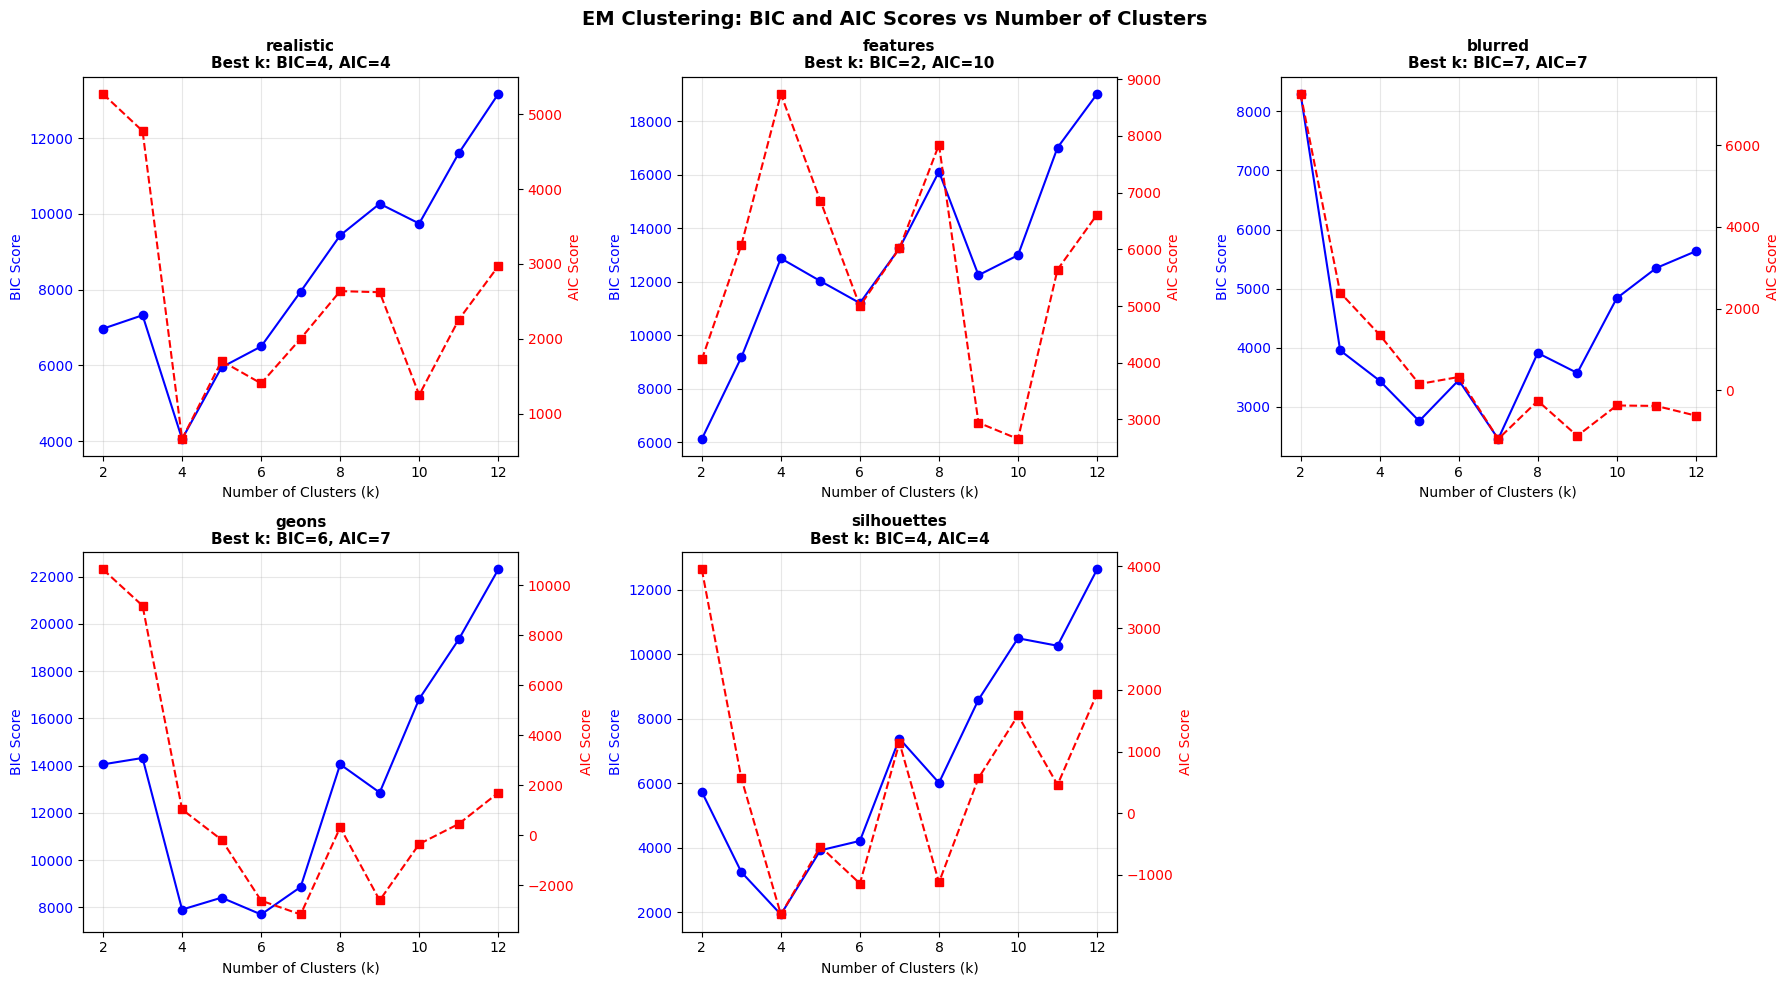

In [90]:
from sklearn.mixture import GaussianMixture

k_range = range(2, 13)
gmm_results = {}

print("="*70)
print("Determining Optimal Number of Clusters using BIC and AIC")
print("="*70)
print()

for label in LABELS:
    cumulative_variance = pca_results[label]['cumulative_variance']
    minimum_components = numpy.argmax(cumulative_variance >= 0.95) + 1 if numpy.any(cumulative_variance >= 0.95) else len(cumulative_variance)    
    principal_components = pca_results[label]['principal_components'][:, :minimum_components].astype(numpy.float64)
    
    bic_scores = []
    aic_scores = []
    
    for k in k_range:
        gmm = GaussianMixture(
            n_components=k,
            covariance_type='full',
            random_state=42,
            n_init=10,
            reg_covar=1e-6
        )
        gmm.fit(principal_components)
        bic_scores.append(gmm.bic(principal_components))
        aic_scores.append(gmm.aic(principal_components))
    
    best_k_bic = k_range[numpy.argmin(bic_scores)]
    best_k_aic = k_range[numpy.argmin(aic_scores)]
    
    gmm_results[label] = {
        'principal_components': principal_components,
        'bic_scores': bic_scores,
        'aic_scores': aic_scores,
        'best_k_bic': best_k_bic,
        'best_k_aic': best_k_aic
    }
    
    print(f"Label: {label}")
    print(f"  Best k (BIC): {best_k_bic}")
    print(f"  Best k (AIC): {best_k_aic}")
    if label != LABELS[-1]:
        print()

figure, axes = plot.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for index, label in enumerate(LABELS):
    axis = axes[index]
    axis_secondary = axis.twinx()
    
    bic_scores = gmm_results[label]['bic_scores']
    aic_scores = gmm_results[label]['aic_scores']
    
    axis.plot(k_range, bic_scores, marker='o', label='BIC', color='blue')
    axis.set_xlabel("Number of Clusters (k)", fontsize=10)
    axis.set_ylabel("BIC Score", color='blue', fontsize=10)
    axis.tick_params(axis='y', labelcolor='blue')
    
    axis_secondary.plot(k_range, aic_scores, marker='s', linestyle='--', label='AIC', color='red')
    axis_secondary.set_ylabel("AIC Score", color='red', fontsize=10)
    axis_secondary.tick_params(axis='y', labelcolor='red')
    
    axis.set_title(f"{label}\nBest k: BIC={gmm_results[label]['best_k_bic']}, AIC={gmm_results[label]['best_k_aic']}", 
                   fontsize=11, fontweight='bold')
    axis.grid(True, alpha=0.3)

if len(LABELS) < len(axes):
    figure.delaxes(axes[-1])

plot.suptitle('EM Clustering: BIC and AIC Scores vs Number of Clusters', fontsize=14, fontweight='bold')
plot.tight_layout()
plot.show()

## **EM Clustering with k=8 (Ground Truth)**

EM Clustering with k=8

realistic    | accuracy = 0.415
features     | accuracy = 0.357
blurred      | accuracy = 0.476
geons        | accuracy = 0.467
silhouettes  | accuracy = 0.475


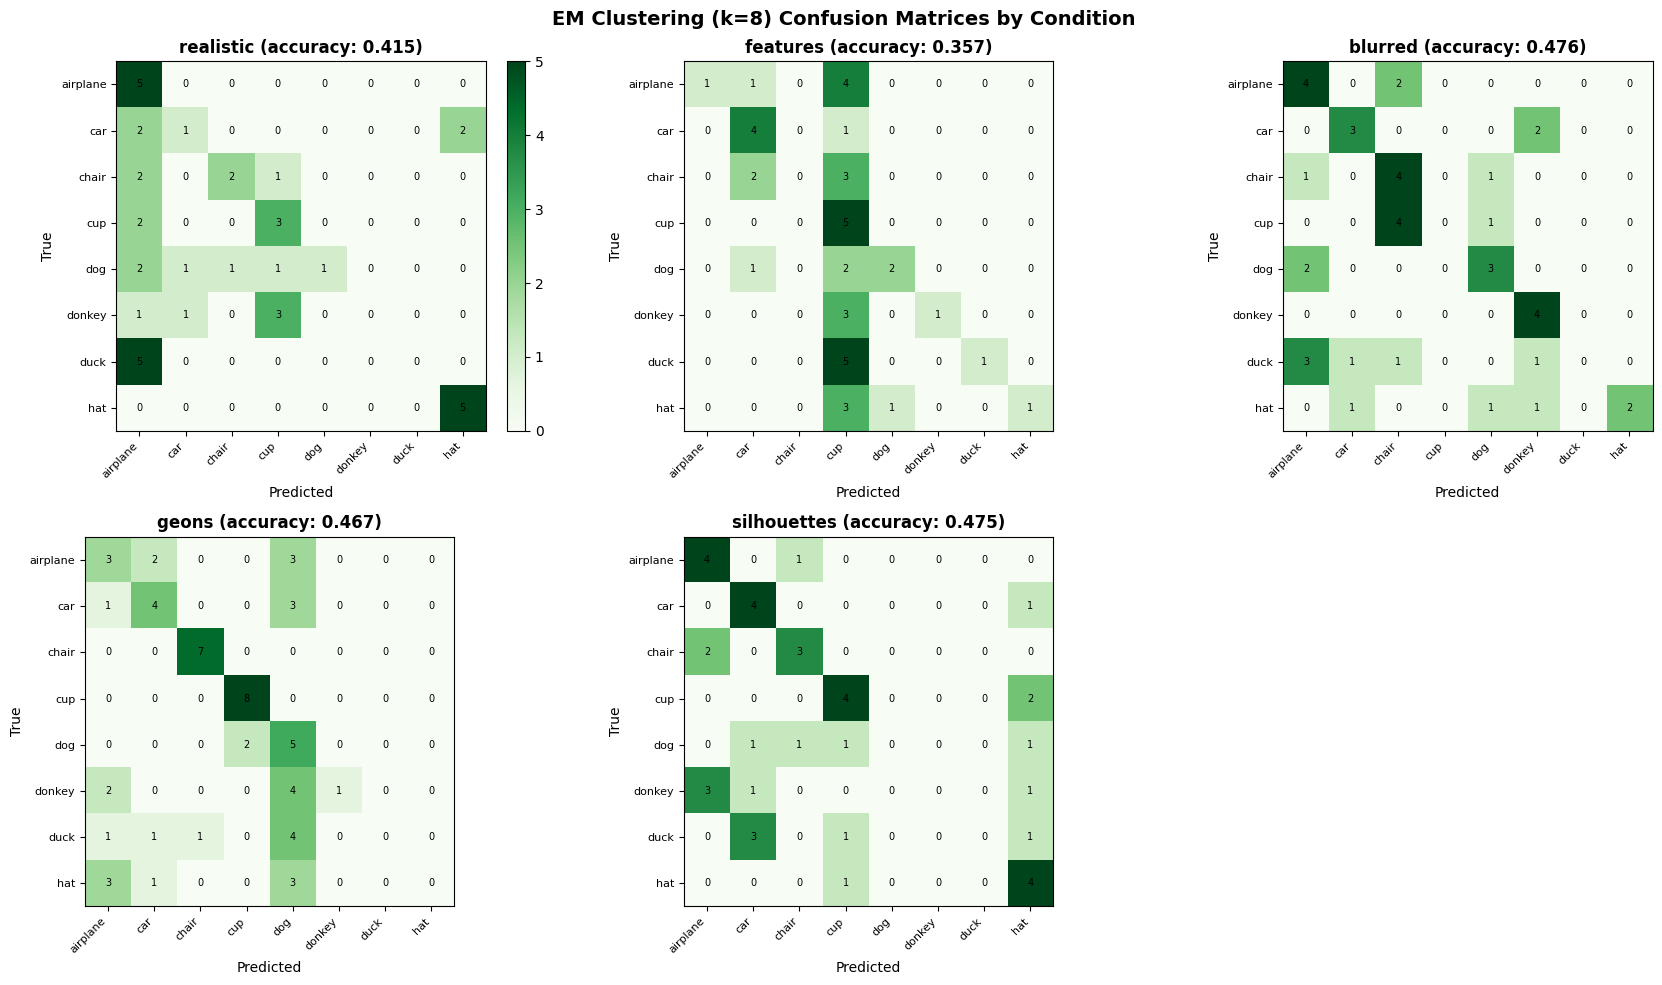

In [91]:
k = 8
gmm_confusion_matrices = {}
gmm_accuracies = {}
gmm_models = {}

print("="*70)
print(f"EM Clustering with k={k}")
print("="*70)
print()

for label in LABELS:
    cumulative_variance = pca_results[label]['cumulative_variance']
    minimum_components = numpy.argmax(cumulative_variance >= 0.95) + 1 if numpy.any(cumulative_variance >= 0.95) else len(cumulative_variance)    
    principal_components = pca_results[label]['principal_components'][:, :minimum_components].astype(numpy.float64)
    
    paths = sorted((PATH / label).iterdir())
    true_labels = []
    for path in paths:
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem.lower()), 'Unknown')
        true_labels.append(cluster_name)
    true_labels = numpy.array(true_labels)
    
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=42,
        n_init=10
    )
    gmm.fit(principal_components)
    cluster_ids = gmm.predict(principal_components)
    
    cluster_to_class = {}
    for cluster_id in range(k):
        mask = cluster_ids == cluster_id
        if not numpy.any(mask):
            continue
        values, counts = numpy.unique(true_labels[mask], return_counts=True)
        majority_class = values[numpy.argmax(counts)]
        cluster_to_class[cluster_id] = majority_class
    
    pred_labels = numpy.array([cluster_to_class[c] for c in cluster_ids])
    
    cm = confusion_matrix(true_labels, pred_labels, labels=CLUSTER_NAMES)
    gmm_confusion_matrices[label] = cm
    accuracy = (true_labels == pred_labels).mean()
    gmm_accuracies[label] = accuracy
    gmm_models[label] = {
        'model': gmm,
        'pca_model': pca_results[label]['pca_model'],
        'scaler': pca_results[label]['scaler'],
        'n_components': minimum_components
    }
    
    print(f"{label:12s} | accuracy = {accuracy:.3f}")

figure, axes = plot.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for index, label in enumerate(LABELS):
    ax = axes[index]
    cm = gmm_confusion_matrices[label]
    im = ax.imshow(cm, cmap='Greens')
    ax.set_title(f"{label} (accuracy: {gmm_accuracies[label]:.3f})", fontsize=12, fontweight='bold')
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("True", fontsize=10)
    ax.set_xticks(range(len(CLUSTER_NAMES)))
    ax.set_xticklabels(CLUSTER_NAMES, rotation=45, ha="right", fontsize=8)
    ax.set_yticks(range(len(CLUSTER_NAMES)))
    ax.set_yticklabels(CLUSTER_NAMES, fontsize=8)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=7)
    
    if index == 0:
        figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

for j in range(len(LABELS), len(axes)):
    figure.delaxes(axes[j])

plot.suptitle(f"EM Clustering (k={k}) Confusion Matrices by Condition", fontsize=14, fontweight='bold')
plot.tight_layout()
plot.show()

## **Generating New Images Using GMM sample()**

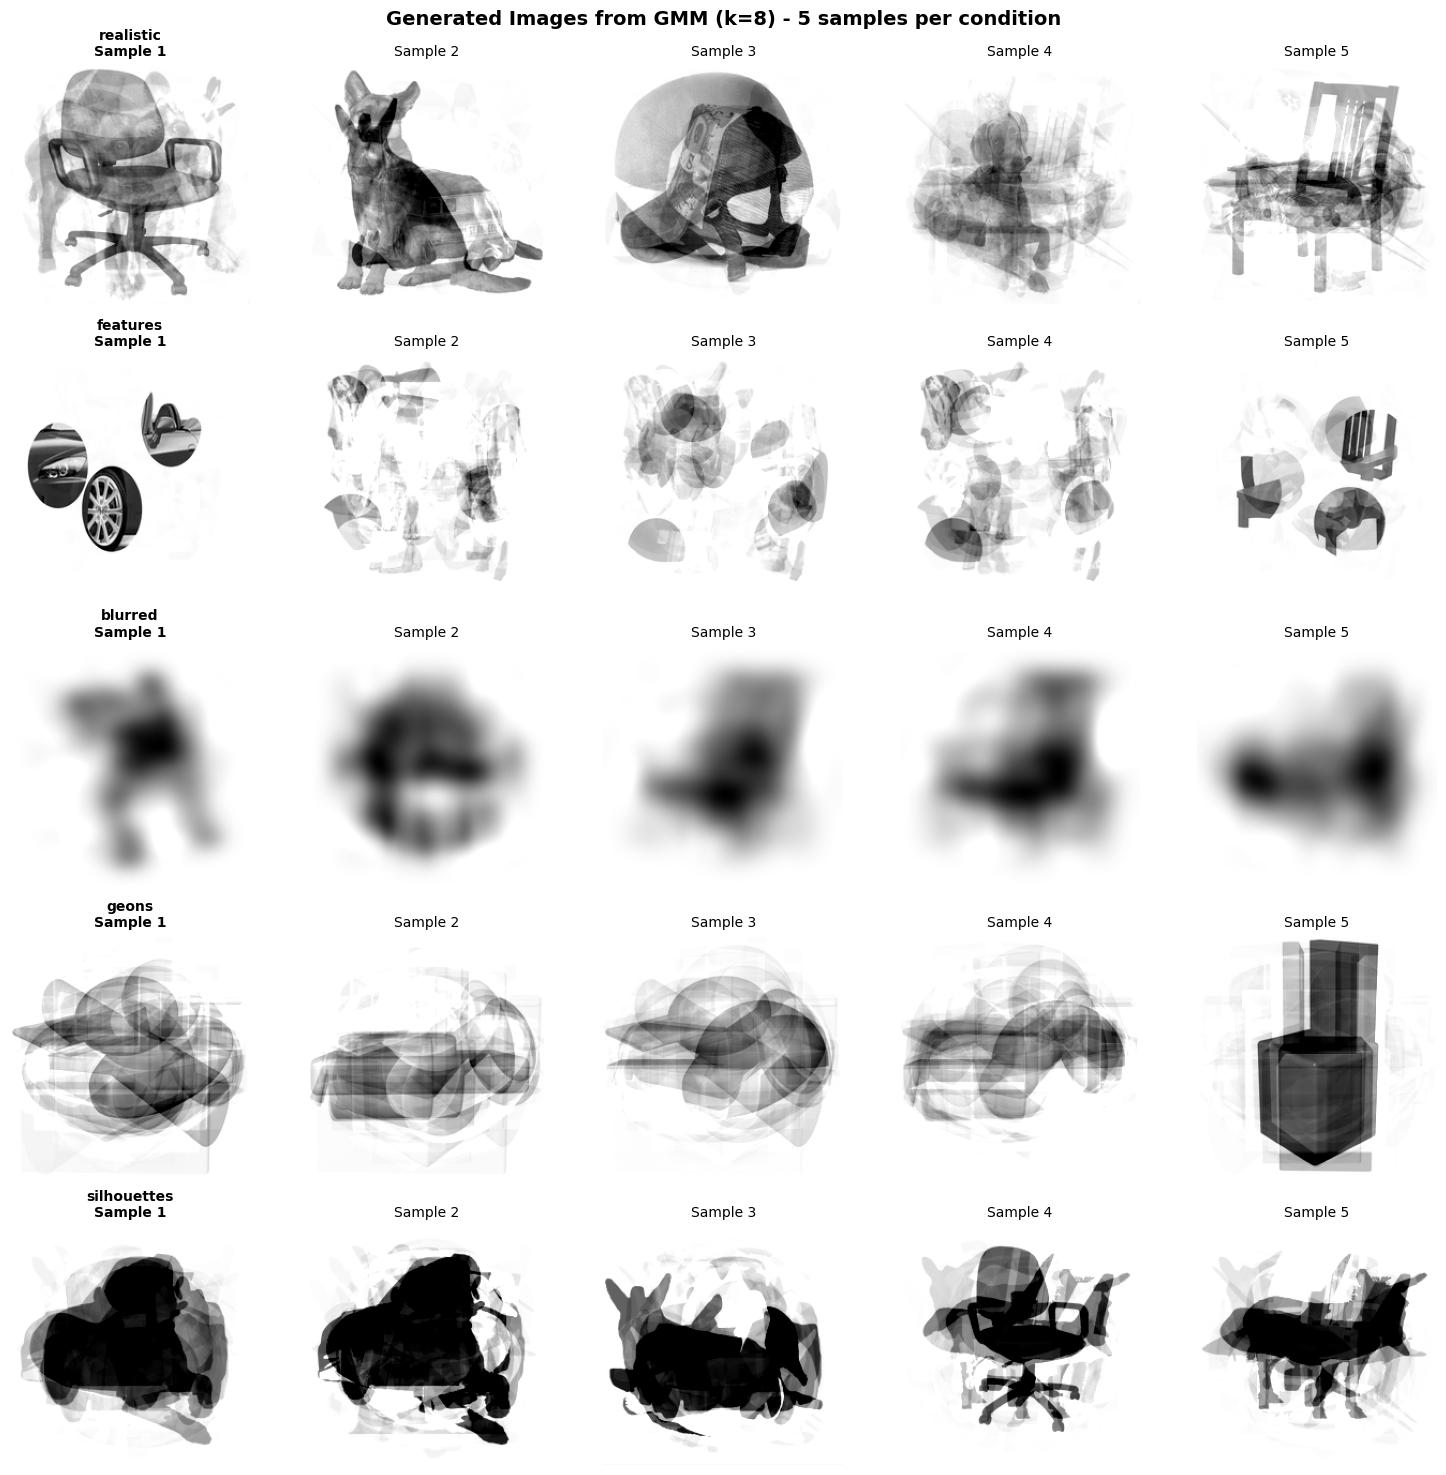

In [92]:
n_samples = 5
figure, axes = plot.subplots(len(LABELS), n_samples, figsize=(15, 3*len(LABELS)))

for row_idx, label in enumerate(LABELS):
    
    gmm = gmm_models[label]['model']
    pca_model = gmm_models[label]['pca_model']
    scaler = gmm_models[label]['scaler']
    n_components = gmm_models[label]['n_components']
    
    samples_pca, _ = gmm.sample(n_samples)
    
    samples_pca_padded = numpy.column_stack([
        samples_pca, 
        numpy.zeros((n_samples, pca_model.n_components_ - n_components))
    ])
    
    samples_standardized = pca_model.inverse_transform(samples_pca_padded)
    samples_original = scaler.inverse_transform(samples_standardized)
    
    for col_idx in range(n_samples):
        ax = axes[row_idx, col_idx]
        image = samples_original[col_idx].reshape(SIZE)
        
        image = numpy.clip(image, 0, 255)
        
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        
        if col_idx == 0:
            ax.set_title(f'{label}\nSample {col_idx+1}', fontsize=10, fontweight='bold')
        else:
            ax.set_title(f'Sample {col_idx+1}', fontsize=10)

plot.suptitle(f'Generated Images from GMM (k={k}) - {n_samples} samples per condition', 
              fontsize=14, fontweight='bold')
plot.tight_layout()
plot.show()

## **EM Clustering with ResNet Features**

Running EM clustering using deep features extracted from a pretrained ResNet-18 model instead of PCA features.

EM Clustering with k = 8 - ResNet Features

realistic    | accuracy = 0.805
features     | accuracy = 0.571
blurred      | accuracy = 0.476
geons        | accuracy = 0.867
silhouettes  | accuracy = 0.800


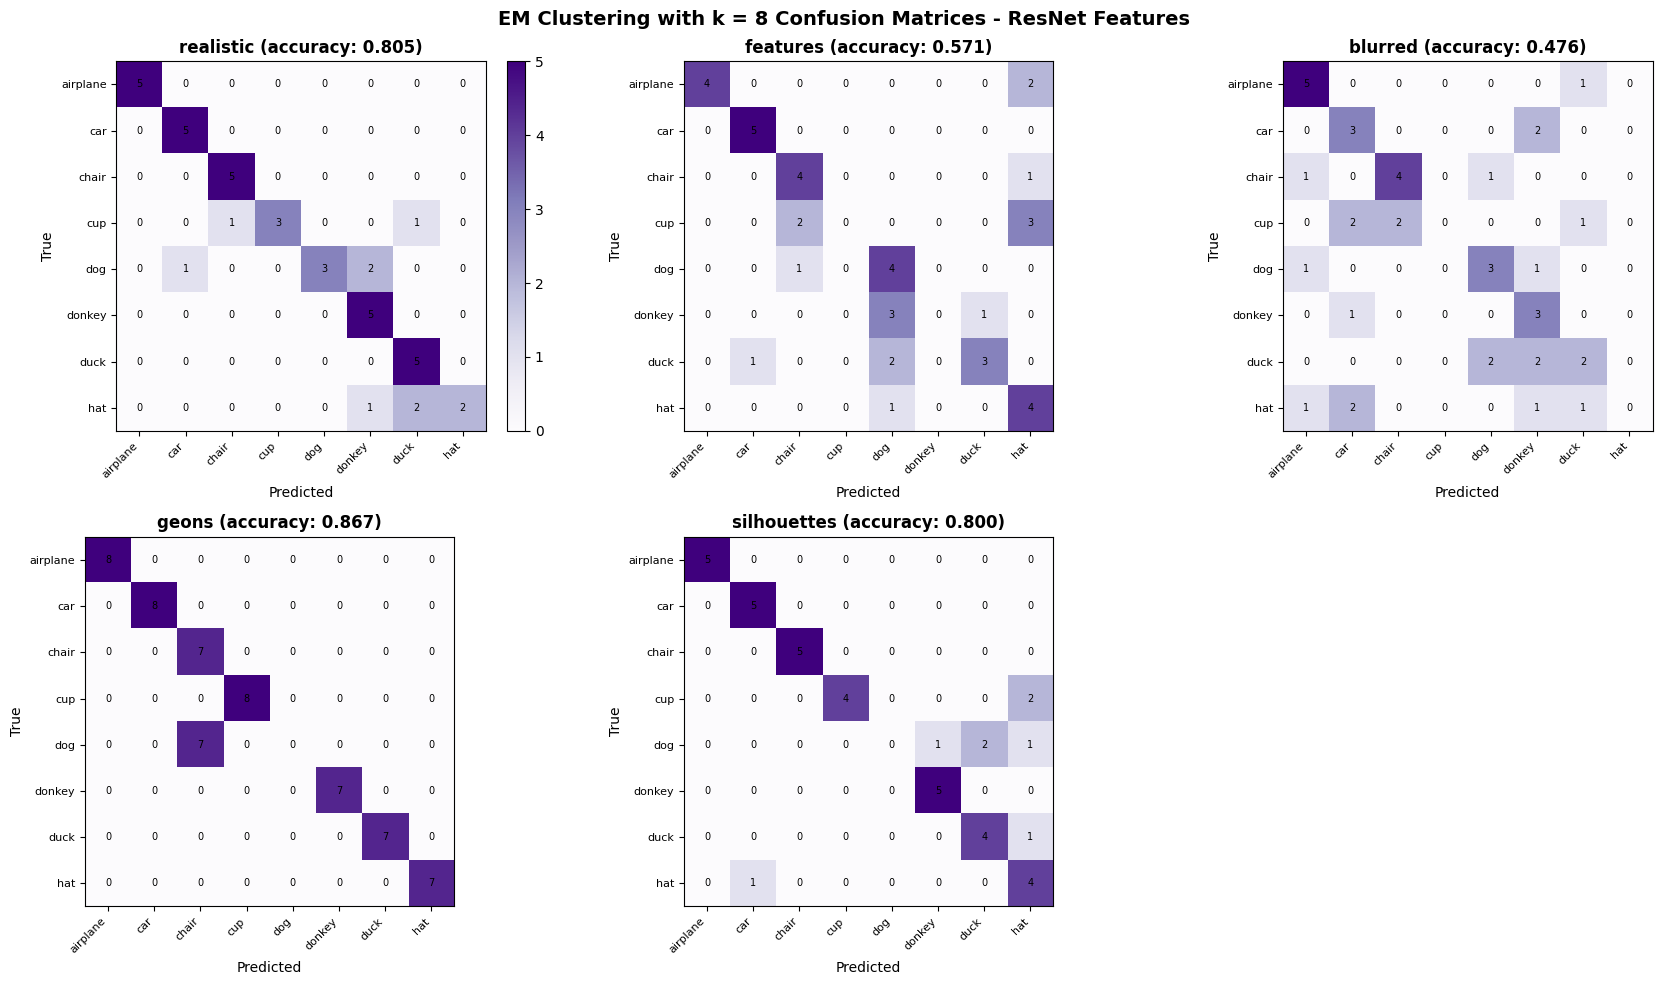

In [93]:
k = 8
gmm_resnet_confusion_matrices = {}
gmm_resnet_accuracies = {}

print("="*70)
print(f"EM Clustering with k = {k} - ResNet Features")
print("="*70)
print()

for label in LABELS:
    features = resnet_features[label].astype(numpy.float64)
    paths = sorted((PATH / label).iterdir())
    true_labels = []
    for path in paths:
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem.lower()), 'Unknown')
        true_labels.append(cluster_name)
    true_labels = numpy.array(true_labels)
    
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=42,
        n_init=10
    )
    gmm.fit(features)
    cluster_ids = gmm.predict(features)
    
    cluster_to_class = {}
    for cluster_id in range(k):
        mask = cluster_ids == cluster_id
        if not numpy.any(mask):
            continue
        values, counts = numpy.unique(true_labels[mask], return_counts=True)
        majority_class = values[numpy.argmax(counts)]
        cluster_to_class[cluster_id] = majority_class
    
    pred_labels = numpy.array([cluster_to_class[c] for c in cluster_ids])
    
    cm = confusion_matrix(true_labels, pred_labels, labels=CLUSTER_NAMES)
    gmm_resnet_confusion_matrices[label] = cm
    accuracy = (true_labels == pred_labels).mean()
    gmm_resnet_accuracies[label] = accuracy
    
    print(f"{label:12s} | accuracy = {accuracy:.3f}")

figure, axes = plot.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for index, label in enumerate(LABELS):
    ax = axes[index]
    cm = gmm_resnet_confusion_matrices[label]
    im = ax.imshow(cm, cmap='Purples')
    ax.set_title(f"{label} (accuracy: {gmm_resnet_accuracies[label]:.3f})", fontsize=12, fontweight='bold')
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("True", fontsize=10)
    ax.set_xticks(range(len(CLUSTER_NAMES)))
    ax.set_xticklabels(CLUSTER_NAMES, rotation=45, ha="right", fontsize=8)
    ax.set_yticks(range(len(CLUSTER_NAMES)))
    ax.set_yticklabels(CLUSTER_NAMES, fontsize=8)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=7)
    
    if index == 0:
        figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

for j in range(len(LABELS), len(axes)):
    figure.delaxes(axes[j])

plot.suptitle(f"EM Clustering with k = {k} Confusion Matrices - ResNet Features", fontsize=14, fontweight='bold')
plot.tight_layout()
plot.show()